In [1]:
from os import listdir
from os.path import isfile, join
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet

from scarlet_extensions.initialization.detection import makeCatalog, Data, mad_wavelet
import sep
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
from astropy.nddata import Cutout2D
import warnings
warnings.simplefilter("ignore")

In [2]:
def makeCatalog(datas, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=4).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet.from_image(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet.from_image(detect_image).coefficients
            detect = wave_detect[0] + wave_detect[1] + wave_detect[2]
        else:
            detect = detect_image
    
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)

    if type(datas) is np.ndarray:
        bg_rms = mad_wavelet(datas)
    else:
        bg_rms = []
        for data in datas:
            bg_rms.append(mad_wavelet(data.images))

    return catalog, bg_rms

#Display function
def display_init(blend, obs, data, ids, img, title, save = False):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=hsc_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        print('zizi')
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data", fontsize=20)
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model", fontsize=20)
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals", fontsize=20)
    if save is True:
        plt.savefig(title+'_'+str(coord[0])+'_'+str(coord[1])+'.png')
    pass

In [3]:
names = ['SDSSJ0240',
         'NGC1052-DF1',
         'T20-12000',
         'LSB21 ',
         'LBT1']

No handles with labels found to put in legend.


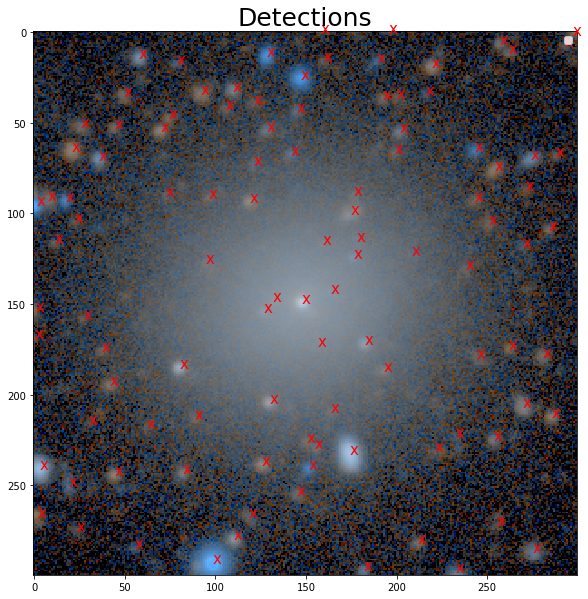

CPU times: user 1min 30s, sys: 6.31 s, total: 1min 36s
Wall time: 1min 37s
scarlet ran for 200 iterations to logL = -868064.7688740115


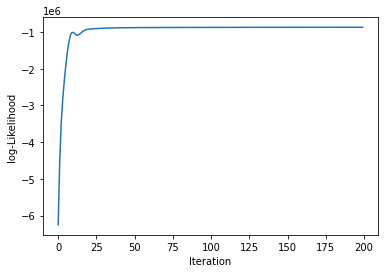

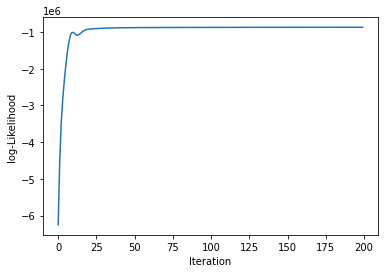

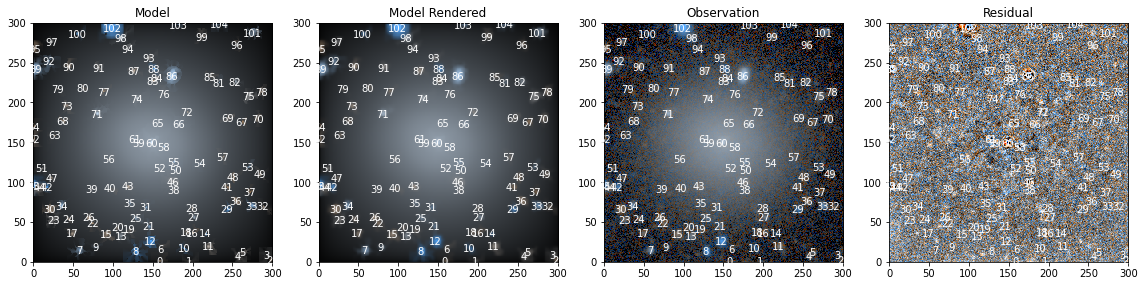

No handles with labels found to put in legend.


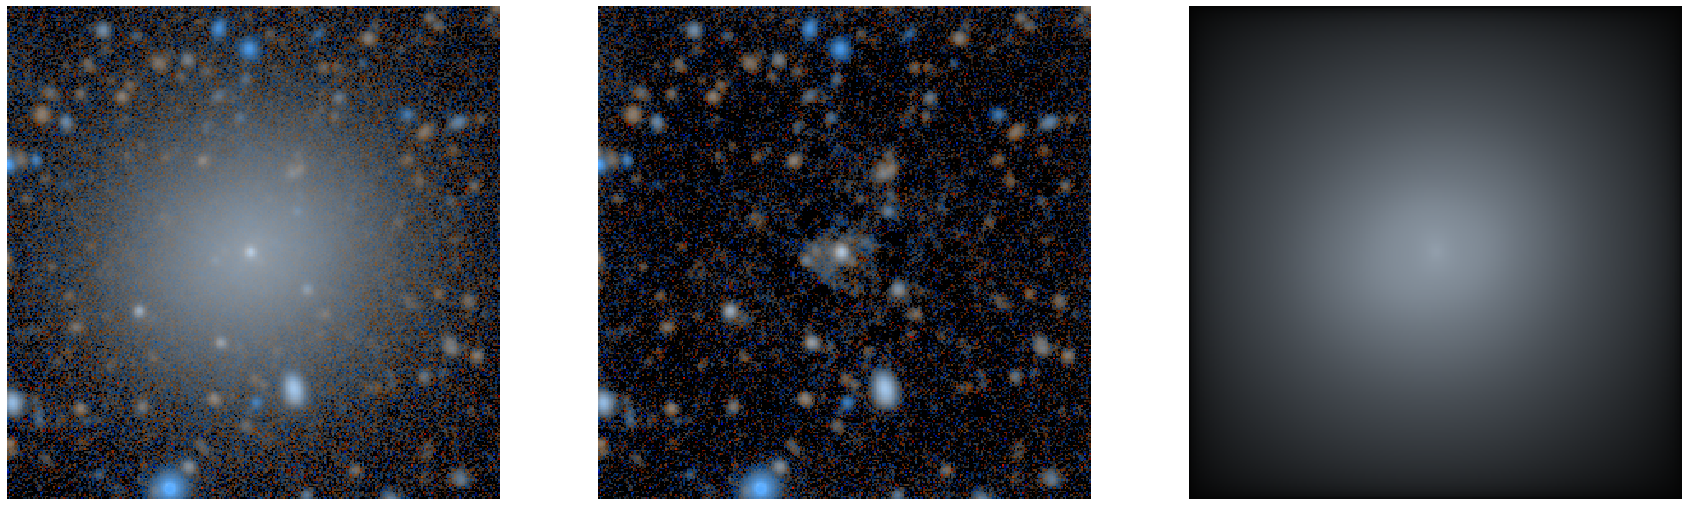

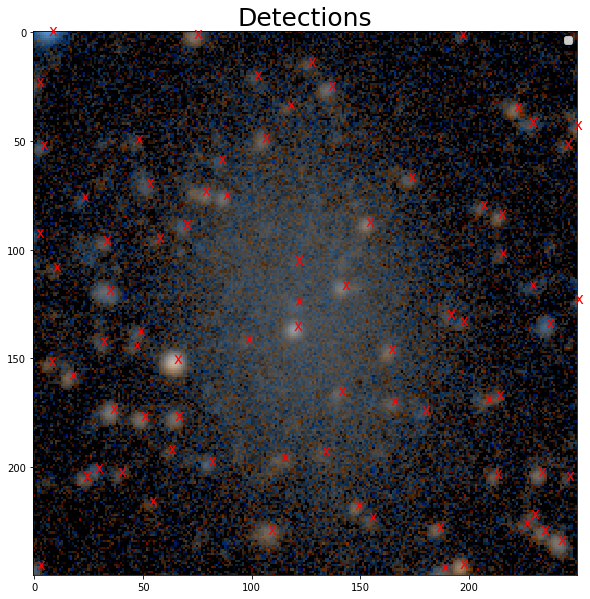

CPU times: user 29 s, sys: 1.24 s, total: 30.2 s
Wall time: 29.8 s
scarlet ran for 100 iterations to logL = -557444.245196043


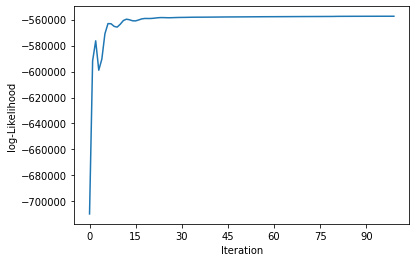

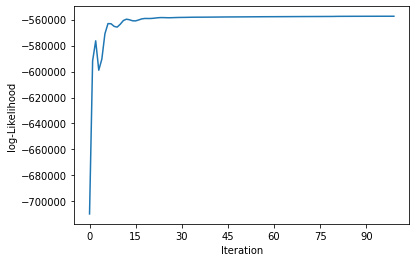

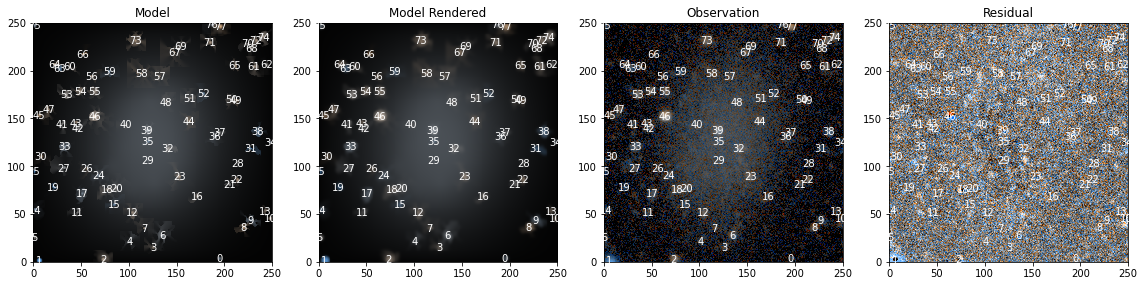

No handles with labels found to put in legend.


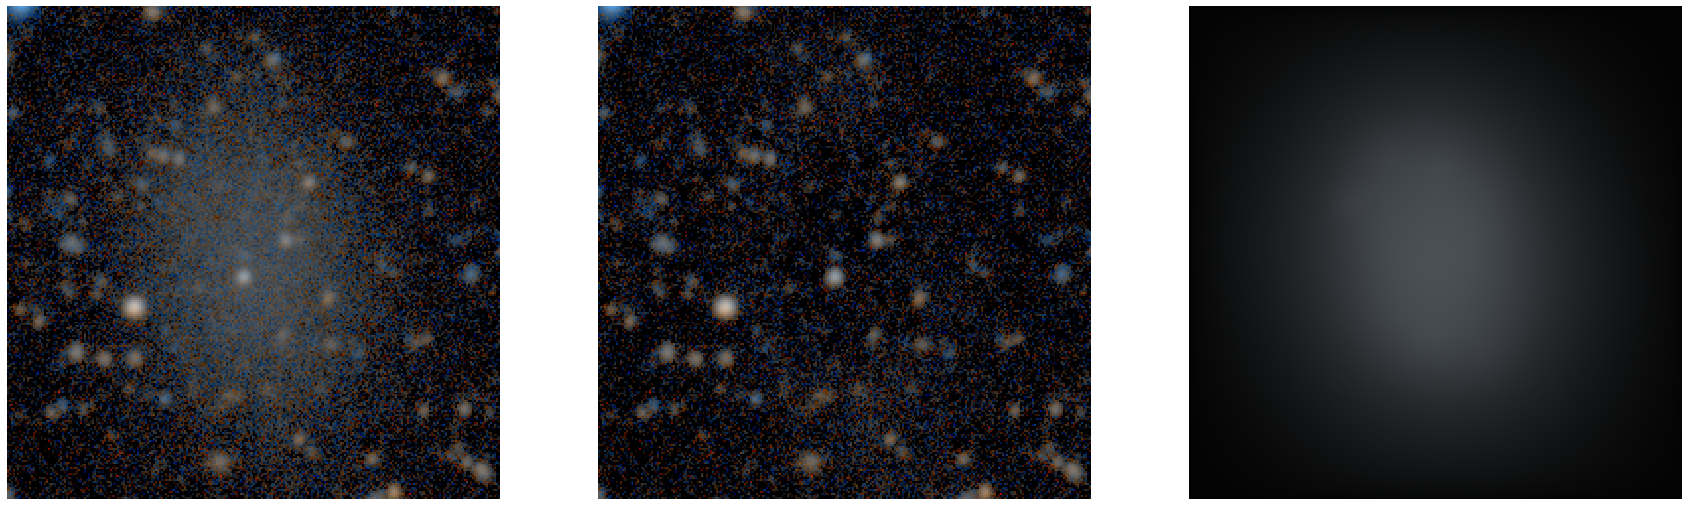

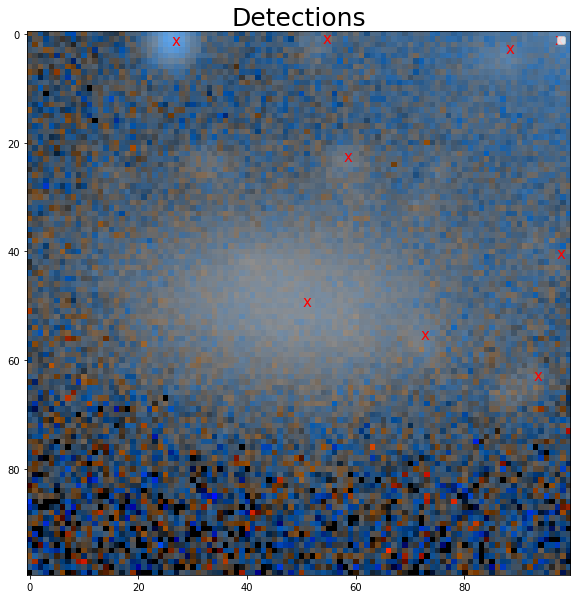

CPU times: user 7.12 s, sys: 538 ms, total: 7.66 s
Wall time: 7.27 s
scarlet ran for 200 iterations to logL = -110475.28866137964


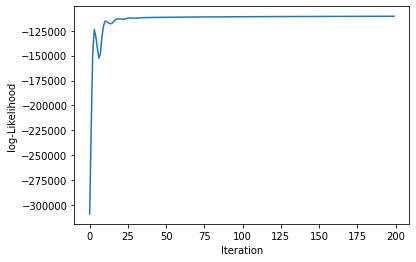

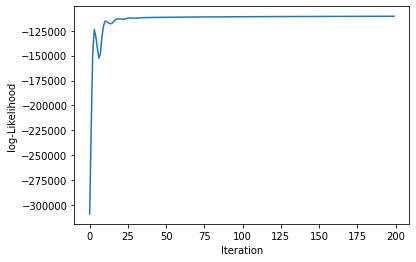

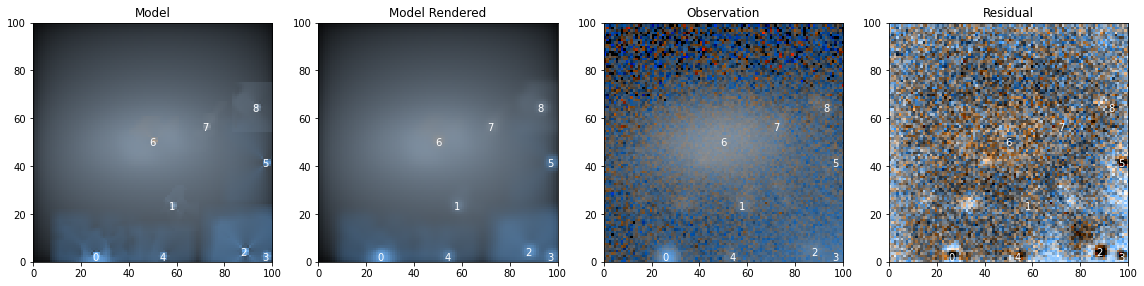

No handles with labels found to put in legend.


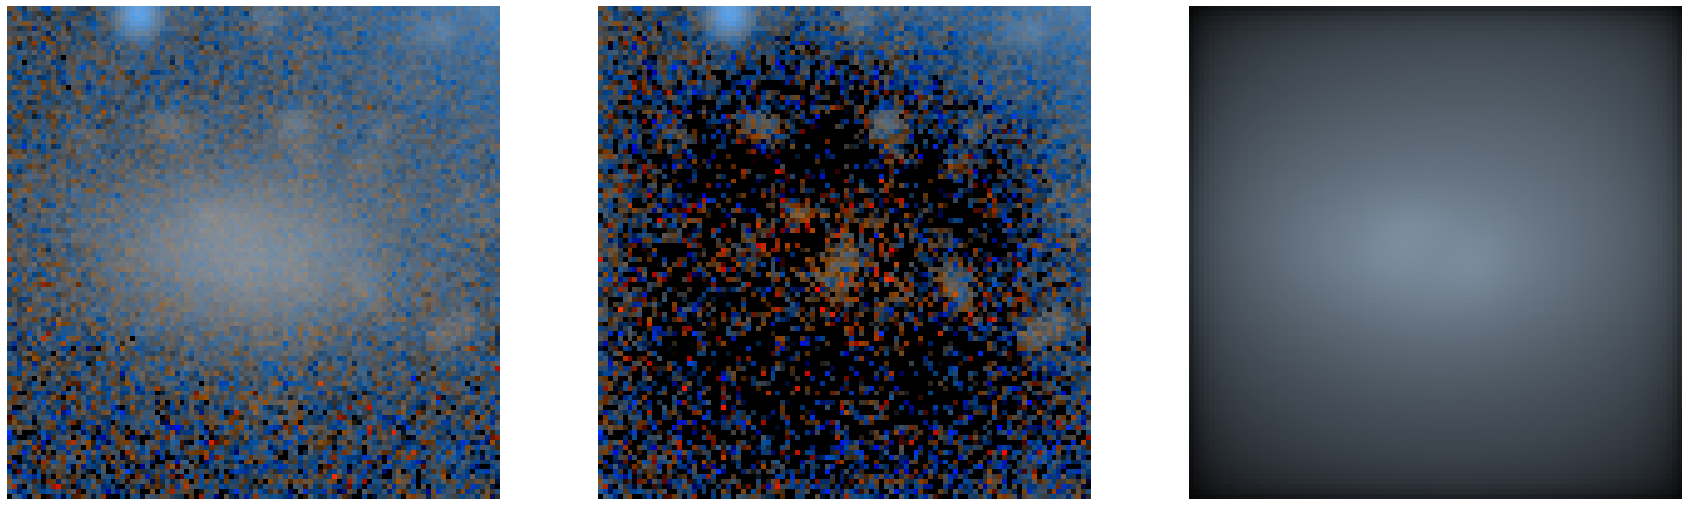

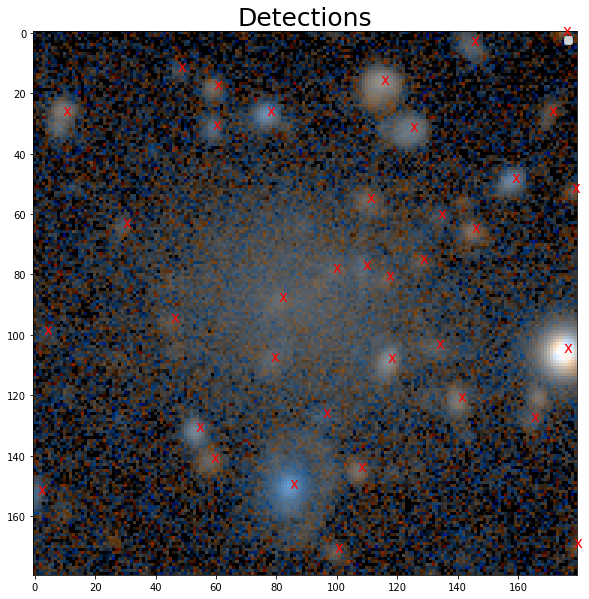

CPU times: user 26.2 s, sys: 1.04 s, total: 27.2 s
Wall time: 27.3 s
scarlet ran for 139 iterations to logL = -1229320.4709360055


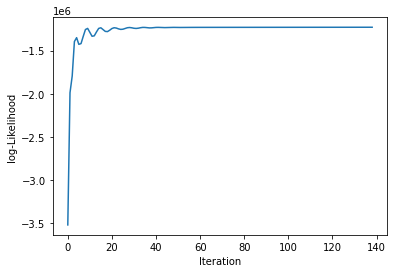

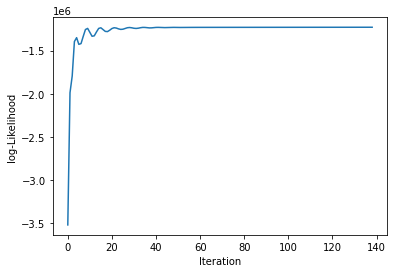

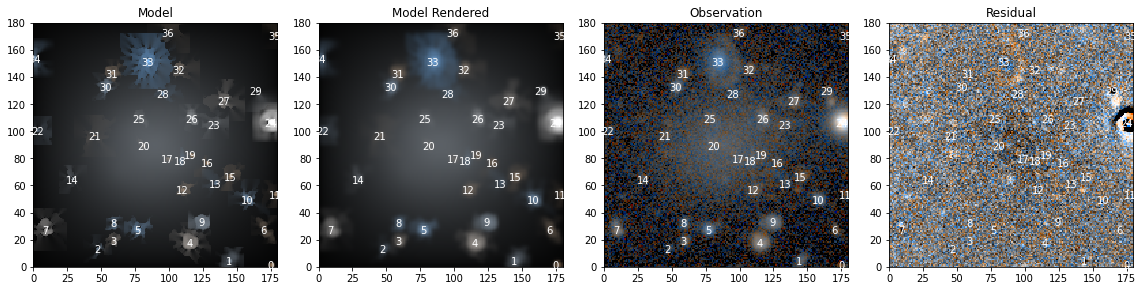

No handles with labels found to put in legend.


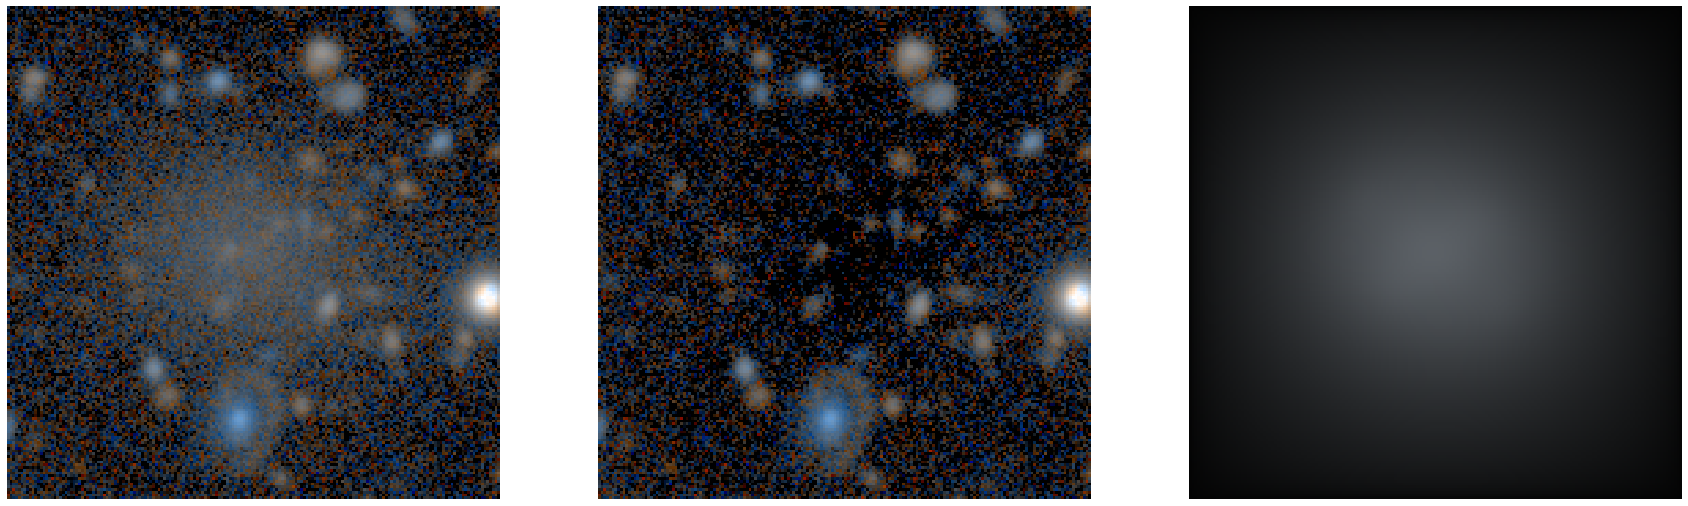

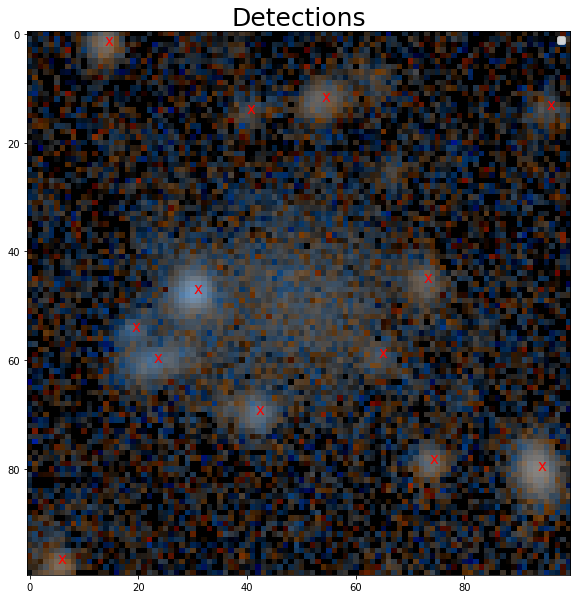

CPU times: user 10.4 s, sys: 549 ms, total: 10.9 s
Wall time: 10.5 s
scarlet ran for 168 iterations to logL = -88245.46387084


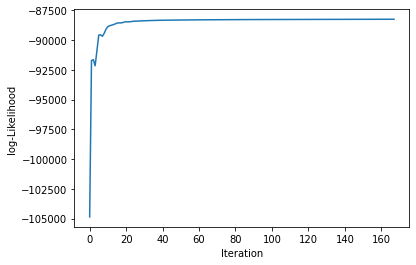

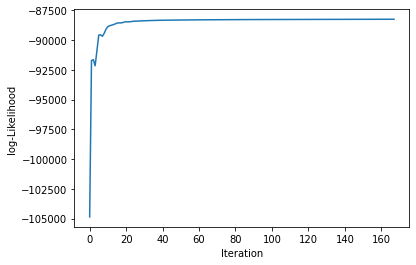

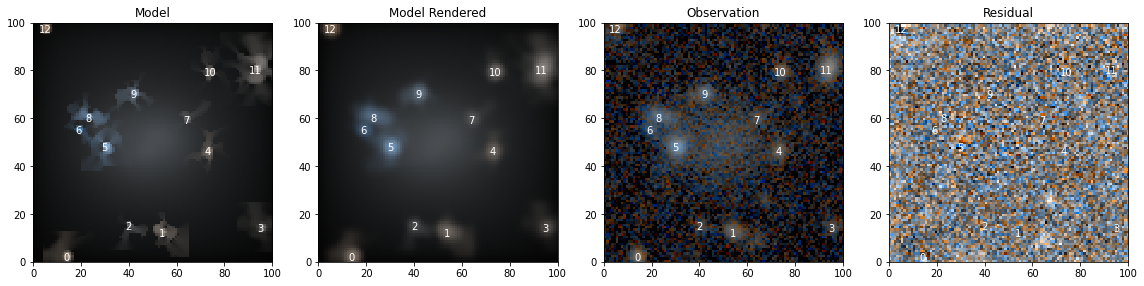

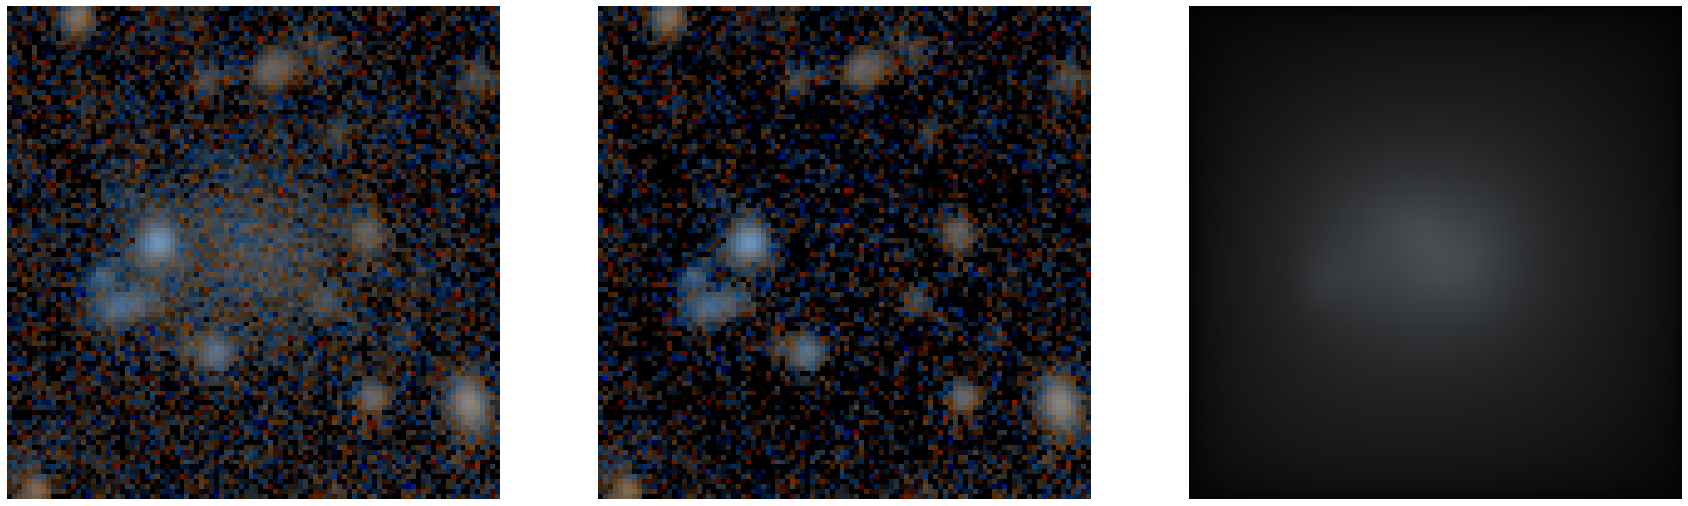

In [4]:
for n in names:
    hdu = fits.open(f'Data/LBT/Cutouts/cut_{n}.fits')
    cube = hdu[0].data
    
    wcs = WCS(hdu[0].header)
        
    cube = np.array(cube)
    psfs = scarlet.GaussianPSF( 0.9/0.2254/(2.*(2*np.log(2))**0.5))
    channels = ['R','G']
    
    n,nx,ny = np.shape(cube)
    
    data = {
        "images": cube, 
        "psfs":psfs,
        "wcs":wcs,
        "channels": channels}
    
    #Detection step. we identify all the source that we have to model.
    wave = True #True means wavelet detection. False is regular detection with sep. True is advised in this specific case
    
    lvl = 2
    #Lower to get more faint sources. For source '6' and '7', lvl=4 is good, but for most other sources (25 for instance) you need to go down to 2 if you want to pick on the faint blended blobs
    
    catalog, bg_rms = makeCatalog(cube, lvl, wave)
    
    weights = np.ones_like(cube) / (bg_rms**2)[:, None, None]
    
    # Create a color mapping for the HSC image
    display_norm = AsinhMapping(minimum=-1, stretch=100, Q=10)
    
    # Get the source coordinates from the HST catalog
    pixel = np.stack((catalog['y'], catalog['x']), axis=1)
    
    # Convert the HST coordinates to the HSC WCS
    # Map the HSC image to RGB
    img_rgb = scarlet.display.img_to_rgb(cube, norm=display_norm)
    plt.figure(figsize=(10,10))

    plt.imshow(img_rgb)
    #plt.axis('off')
    
    for k,p in enumerate(pixel):
        plt.text(p[1], p[0], 'x', color="r", fontsize = 15)
    plt.legend()
    plt.title("Detections", fontsize = 25)
    
    plt.show()
    
    # This is the residual PSF of the model as we don't fully deconvolve images. 
    model_psf = scarlet.GaussianPSF(sigma = 0.8)
    
    # The frame describes where the model lives
    model_frame = scarlet.Frame(
        cube.shape,
        psf=model_psf,
        channels=channels)
    
    # The observation describes where the data live and how to go from the model to the data.  
    observation = scarlet.Observation(
        cube, 
        psf= psfs, 
        weights=weights, 
        channels=channels).match(model_frame)
    
    starlet_sources = []
    for k,src in enumerate(catalog):
    
            new_source = scarlet.ExtendedSource(model_frame, 
                                            (src['y'], src['x']), 
                                            observation, 
                                            K=1, compact = True)
            starlet_sources.append(new_source)
    
    new_source = scarlet.StarletSource(model_frame, 
                            (nx/2, ny/2), [observation], 
                            thresh = 0.01,
                            starlet_thresh = 1,
                            boxsize = cube.shape[1],
                            spectrum = np.array([.9,0.1]))
                                       
    starlet_sources.append(new_source)  
    
    #new_source = scarlet.StarletSource(model_frame, 
    #                        (nx/2, ny/2), [observation], 
    #                        thresh = 0.01,
    #                        starlet_thresh = 1,
    #                        boxsize = cube.shape[1],
    #                        spectrum = np.array([0.,1.]))
    #starlet_sources.append(new_source)  
    
    starlet_blend = scarlet.Blend(starlet_sources, observation)
    
    %time it, logL = starlet_blend.fit(200, e_rel=1e-6)
    print(f"scarlet ran for {it} iterations to logL = {logL}")
    scarlet.display.show_likelihood(starlet_blend)
    plt.show()
    
    scarlet.display.show_likelihood(starlet_blend)
    plt.show()
    scarlet.display.show_scene(starlet_sources, 
                           norm=display_norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True,
                          )
    plt.show()
    
    lsbg = starlet_sources[-1].get_model(frame=model_frame)
    model = 0
    
    lsbg = observation.render(lsbg)
    res_rgb = scarlet.display.img_to_rgb(cube-lsbg, norm=display_norm)
    img_rgb = scarlet.display.img_to_rgb(cube, norm=display_norm)
    lsbg_rgb = scarlet.display.img_to_rgb(lsbg, norm=display_norm)
    
    plt.figure(figsize = (30,15))
    plt.subplot(131)
    plt.imshow(img_rgb)
    #for k in range(len(catalog["x"])):
    #    plt.text(catalog["x"][k], catalog["y"][k], k, color = 'c', fontsize = 21)
    #plt.plot(catalog["x"], catalog["y"], 'co')
    plt.axis("off")
    
    plt.subplot(133)
    plt.imshow(lsbg_rgb)
    plt.axis("off")
    
    plt.subplot(132)
    plt.imshow(res_rgb)
    plt.axis("off")